This notebook contains numerical studies comparing the computational performance of the all-at-once scheme vs the streaming algorithm. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from test_functions import *

import streaming_data_gsa as sdg
from tqdm import tqdm

from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble']=r'\usepackage{amsfonts}'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
import matplotlib.pyplot as plt

# Custom formatter to show scientific notation without offset
from matplotlib.ticker import FuncFormatter
def sci_formatter(x, significant_digits=1):
    s = f'{x:.{significant_digits}e}'
    s = s.replace('e+0', 'e').replace('e-0','e-').replace('e0','')
    return s

In [2]:
figdir='figs/heuristic_results'
if not os.path.exists(figdir): os.makedirs(figdir)

# First of all, when is the noise distribution actually symmetric about zero?

We hypothesize it has to do with the skewness of the output distribution. The idea is that because you have very few, very large samples, it has outsize influence on the sample statistics and can cause more skewed noise distributions.

We test this out by increasing the skewness of the output distribution while maintaining constant variance. We set the output distribution to be a gamma random variable. The skewness of the gamma distribution with shape $\alpha$ is $2/\sqrt{\alpha}$, so smaller $\alpha$ will be more skewed. At the same time, the variance of a gamma distribution is $\alpha \theta^2$, so we set $\theta=\alpha^{-0.5}$ so that the variance is equal to 1 for all $\alpha$ values.

In [3]:
alphas = np.array([.1, .01, .001])
scales = alphas**(-0.5)
rvs = [ ss.gamma(a=alpha, scale=scale) for alpha, scale in zip(alphas, scales)]
y_skewnesses = [ rv.stats(moments='s') for rv in rvs ]
y_skewnesses

[np.float64(6.324555320336758),
 np.float64(20.0),
 np.float64(63.24555320336759)]

In [4]:
np.random.seed(20250722)
n_samples = [1000, 10000, 100000]
n_replicates = 1000
skewnesses = np.zeros((len(alphas), len(n_samples)))
dummy_sobols = np.zeros((len(alphas), len(n_samples), n_replicates))
urv = ss.uniform()
for i, rv in enumerate(rvs):
    for j, ns in enumerate(n_samples):
        Y = rv.rvs(ns)
        Xdummy = urv.rvs((ns, n_replicates))
        gsa = sdg.StreamingDataGSABatched(n_replicates,1,50,ns, binning_method='dx', bin_to_inf=True)
        gsa.process_samples(Xdummy,Y)
        dummy_sobols[i,j] = gsa.get_sobol_indices()
        skewnesses[i,j] = ss.skew(dummy_sobols[i,j])

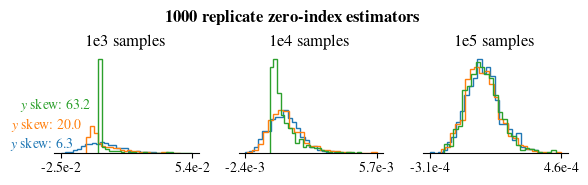

In [5]:
fig = plt.figure(figsize=(6,2))
axs = fig.subplots(1,3)
for i, (ax, ns) in enumerate(zip(axs,n_samples)):
    ds = dummy_sobols[:,i]
    ax.set_xticks([ds.min(), ds.max()])
    ax.set_xticklabels([sci_formatter(ds.min()),sci_formatter(ds.max())])
    ax.set_title(f'{sci_formatter(ns,0)} samples')

    for j, dsj in enumerate(ds):
        ax.hist(dsj, density=True, histtype='step', bins=25);
        ax.set_yticks([])
        ax.spines[['top','right','left']].set_visible(False)

axs[0].annotate(fr'$y$ skew: {y_skewnesses[0]:.1f}', (-1.75e-2,5), va='bottom', ha='right', color='C0')
axs[0].annotate(fr'$y$ skew: {y_skewnesses[1]:.1f}', (-1.25e-2,80), va='bottom', ha='right', color='C1')
axs[0].annotate(fr'$y$ skew: {y_skewnesses[2]:.1f}', (-0.75e-2,155), va='bottom', ha='right', color='C2')
fig.suptitle(r'\textbf{1000 replicate zero-index estimators}', y=0.9)
fig.tight_layout()
fig.savefig(f'{figdir}/gamma_dist_noise_distributions.pdf', bbox_inches='tight')

What does the convergence rate in the noise distribution look like?

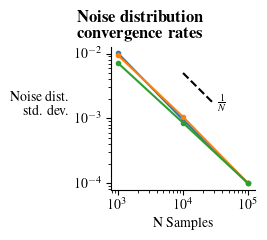

In [6]:
fig = plt.figure(figsize=(3.5,2.5))
ax = fig.add_subplot(111)
for i, (sobols, sk) in enumerate(zip(dummy_sobols, skewnesses)):
    stds = sobols.std(axis=1)
    ax.loglog(n_samples, stds, '.-')

rate_x = np.linspace(10**(4), 10**(4.45), 100)
rate_y = 50*rate_x**(-1)
ax.loglog(rate_x, rate_y, 'k--')
ax.annotate(r'$\frac{1}{N}$', (rate_x[-1]*1.35, rate_y[-1]), ha='center', va='center')

ax.set_box_aspect(1)
ax.spines[['top','right']].set_visible(False)
ax.set_ylabel('Noise dist.\nstd. dev.', rotation=0, ha='right')
ax.set_xlabel('N Samples')
ax.set_title(r'\textbf{Noise distribution}'+'\n'+r'\textbf{convergence rates}', x=0.2)
fig.tight_layout()
fig.savefig(f'{figdir}/noise_std_convergence_rate.pdf', bbox_inches='tight')


Now let's test the heuristic on the Sobol' G function

In [7]:
a1000 = np.arange(1000)**0.5
m1000 = SobolG(1000,a=a1000)

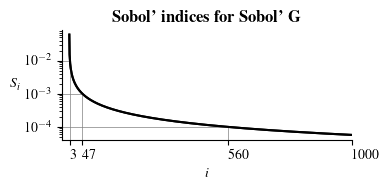

In [8]:
last_ind_gt = lambda x: np.argwhere(m1000.main_effects > x)[-1][0]+1
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
inds=1+np.arange(1000)
ax.set_xticks([])
ax.set_xticks([last_ind_gt(1e-2), last_ind_gt(1e-3), last_ind_gt(1e-4), 1000])
yts = [1e-2, 1e-3, 1e-4]
xts = [ last_ind_gt(yt) for yt in yts ]
ax.semilogy(inds, m1000.main_effects, 'k')

for i, (xt, yt) in enumerate(zip(xts, yts)):
    ax.vlines(xt, ax.get_ylim()[0], yt, lw=0.5, color='grey')
    ax.hlines(yt, -25, xt, lw=0.5, color='grey')
ax.semilogy(inds, m1000.main_effects, 'k')
ax.set_xlim([-25,1000])
#ax.grid()
#ax.set_axisbelow(True)
ax.set_xticklabels(ax.get_xticks(), ha='left')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$S_i$', rotation=0, ha='right', va='center')
ax.spines[['top','right']].set_visible(False)
ax.set_title(r"\textbf{Sobol' indices for Sobol' G}")
fig.tight_layout()
fig.savefig(f'{figdir}/sobol_g_indices.pdf', bbox_inches='tight')

In [9]:
m1000.main_effects.sum()

np.float64(0.35102539406927813)

This gives us Sobol' index values that start out quite small, but we have a few that we can pick out as being significant.

What is the skewness of this function?

In [10]:
np.random.seed(20250726)
n_rep = 10
ns = int(1e6)
m1000_skew = np.zeros(n_rep)
for i in tqdm(range(n_rep)):
    m1000_skew[i] = ss.skew(m1000.evaluate(m1000.generate_samples(ns)))

100%|██████████| 10/10 [03:09<00:00, 18.90s/it]


In [11]:
m1000_skew.min(), m1000_skew.max(), m1000_skew.mean()

(np.float64(11.780306925129212),
 np.float64(15.395946683359494),
 np.float64(13.62756382072937))

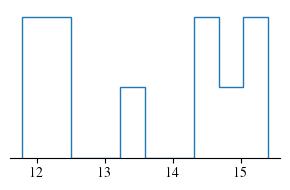

In [12]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(m1000_skew, histtype='step')
ax.set_yticks([])
ax.spines[['left','top','right']].set_visible(False)
fig.tight_layout()

Given our previous analyses, we should expect that the linear function here would require possibly even more than 1e5 samples for the noise distribution to be approximately symmetric. 

Since this model is more highly skewed than what we have observed in our application problems (meaning it is a "conservative" case for us), and because it exhibits the other properties we wish to mimic from our application problem (namely, many parameters with small indices), we proceed with this definition of the Sobol' G coefficients for further analysis.

In [13]:
def replicate_dummy_sobols(n_samples=10000, n_replicates=1000, model=m1000, seed=20250626, binning_method='dx'):
    replicate_dummy_sobols=np.zeros((n_replicates))
    np.random.seed(seed)
    Xdummy = model.rv.rvs((n_samples,n_replicates))
    Y = model.evaluate(model.generate_samples(n_samples))

    gsa = sdg.StreamingDataGSABatched(n_replicates, 1, n_bins=50, n_samp_start=n_samples, binning_method=binning_method, bin_to_inf=True)
    gsa.process_samples(Xdummy,Y)
    replicate_dummy_sobols = gsa.get_sobol_indices()
    return replicate_dummy_sobols

Is there increased noise in zero indices when we have more variables? We can test by computing replicate samples of a dummy variable whose index we know is zero. 

In [14]:
def replicate_dummy_vs_numerical_sobols(n_samples=10000, n_replicates=1000, model=m1000, seed=20250626, binning_method='dx'):
    np.random.seed(seed)
    X = model.generate_samples(n_samples)    
    Y = model.evaluate(X)
    gsa = sdg.StreamingDataGSABatched(X.shape[1], 1, n_bins=50, n_samp_start=n_samples, binning_method=binning_method, bin_to_inf=True)
    gsa.process_samples(X,Y)
    sobols = gsa.get_sobol_indices()

    # Get symmetrized distribution from negative Sobol' values
    neg_sobols = sobols[sobols<0]
    symmetrized_sobols = np.hstack((neg_sobols, -neg_sobols))

    replicate_dummy_sobols = np.zeros(n_replicates)
    Xdummy = model.rv.rvs((n_samples,n_replicates))
    gsa = sdg.StreamingDataGSABatched(n_replicates, 1, n_bins=50, n_samp_start=n_samples, binning_method=binning_method, bin_to_inf=True)
    gsa.process_samples(Xdummy,Y)
    replicate_dummy_sobols = gsa.get_sobol_indices()

    four_sigma_dummy = 4 * replicate_dummy_sobols.std(ddof=1)
    four_sigma_symm = 4 * symmetrized_sobols.std(ddof=1)

    fig = plt.figure(figsize=(5,2))
    ax = fig.add_subplot(111)
    ax.hist(replicate_dummy_sobols, bins=30, label="Dummy Sobols", density=True, histtype='step');
    ax.hist(symmetrized_sobols, bins=30, label='Symmetrized Sobols', density=True, histtype='step');

    ylim = ax.get_ylim()[1]
    ax.vlines(four_sigma_dummy, 0, ylim,'C0', linestyles='--')
    ax.vlines(four_sigma_symm, 0, ylim, 'C1', linestyles='--')
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.spines[['left','top','right']].set_visible(False)
    ax.set_yticks([])

    fig.tight_layout()
    return replicate_dummy_sobols.std(ddof=1), symmetrized_sobols.std(ddof=1)

What happens with the 1000 input Sobol' G case using the superlinear coefficients?

In [15]:
np.random.seed(20250726)
n_samples = np.array([1000, 10000, 100000])
nreps=1000
dummy_sobols = np.zeros((n_samples.size, nreps))
for i, ns in enumerate(n_samples):
     dummy_sobols[i] = replicate_dummy_sobols(model=m1000, n_samples=ns, n_replicates=nreps)

In [16]:
np.random.seed(20250726)
empirical_sobols = np.zeros((n_samples.size, m1000.n_params))
for i, ns in enumerate(n_samples):
    X = m1000.generate_samples(ns)    
    Y = m1000.evaluate(X)
    gsa = sdg.StreamingDataGSABatched(X.shape[1], 1, n_bins=50, n_samp_start=ns, binning_method='dx', bin_to_inf=True)
    gsa.process_samples(X,Y)
    empirical_sobols[i] = gsa.get_sobol_indices()

Plotting the procedure

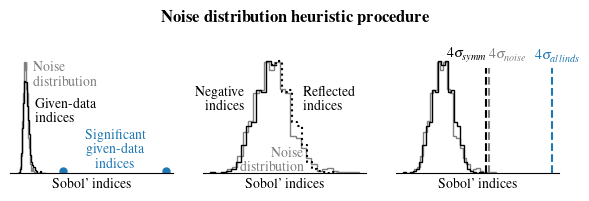

In [30]:
fig = plt.figure(figsize=(6,2))
axs = fig.subplots(1,3, sharey=True)

ds = dummy_sobols[1]
es = empirical_sobols[1]

#####################################
# Step 1
#####################################
axs[0].hist(ds, histtype='step', density=True, color='grey', bins=25);
axs[0].hist(es[es<0.01], histtype='step', density=True, color='k', bins=25);
axs[0].annotate('Noise\ndistribution', (.003, 400), va='center', ha='left', color='grey')
axs[0].annotate('Given-data\nindices', (.0038, 250), va='center', ha='left', color='k')

outliers = es[es>0.01]
axs[0].plot(outliers, 10*np.ones_like(outliers), '.', ms=10)
axs[0].annotate('Significant\ngiven-data\nindices', (outliers.mean(), 10), va='bottom', ha='center', color='C0')

#####################################
# Step 2
#####################################
axs[1].hist(ds, histtype='step', density=True, color='grey', bins=25);
symmetrized_sobols = np.hstack((es[es<0],-es[es<0]))

counts, bin_edges = np.histogram(symmetrized_sobols, bins=25, density=True)

# Build full step-like x and y arrays with endpoints
x_vals = np.repeat(bin_edges, 2)
y_vals = np.zeros_like(x_vals)
y_vals[1:-1:2] = counts
y_vals[2::2] = counts

# Find the index where x = 0 would be inserted
transition_index = np.searchsorted(x_vals, 0)
# Include one point before and one after the transition for both segments
x_left = x_vals[:transition_index + 1]
y_left = y_vals[:transition_index + 1]
x_right = x_vals[transition_index - 1:]
y_right = y_vals[transition_index - 1:]

axs[1].plot(x_left, y_left, 'k', lw=1)
axs[1].plot(x_right, y_right, 'k', lw=1.5, linestyle='dotted')
axs[1].annotate('Negative\nindices', (-.0015, 300), va='center', ha='right', color='k')
axs[1].annotate('Reflected\nindices', (0.0015, 300), va='center', ha='left', color='k')
axs[1].annotate('Noise\ndistribution', (.0015, 52), va='center', ha='right', color='grey')

#####################################
# Step 3
#####################################
axs[2].hist(ds, histtype='step', density=True, color='grey', bins=25);
axs[2].hist(symmetrized_sobols, histtype='step', density=True, color='k', bins=25);
y = 0.9*axs[2].get_ylim()[-1]
axs[2].vlines(4*ds.std(ddof=1), 0, y, 'grey', linestyles='--')
axs[2].vlines(4*symmetrized_sobols.std(ddof=1), 0, y, 'k', linestyles='--')
axs[2].vlines(4*es.std(ddof=1), 0, y, 'C0', linestyles='--')
yscale=1.05
axs[2].annotate(r'$4\sigma_{noise}$', (4*ds.std(ddof=1), yscale*y), va='bottom', ha='left', color='grey');
axs[2].annotate(r'$4\sigma_{symm}$', (4*symmetrized_sobols.std(ddof=1), yscale*y), va='bottom', ha='right', color='black');
axs[2].annotate(r'$4\sigma_{allinds}$', (4*es.std(ddof=1)*1.05, yscale*y), va='bottom', ha='center', color='C0')

for ax in axs:
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel("Sobol' indices")
    ax.set_yticks([])

fig.suptitle(r'\textbf{Noise distribution heuristic procedure}')
fig.tight_layout()
fig.savefig(f'{figdir}/heuristic_procedure.pdf', bbox_inches='tight')

Now plotting these histograms as a function of sample size

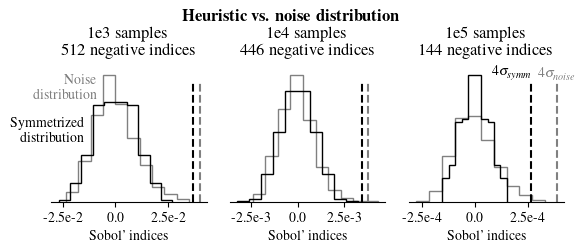

In [18]:
fig = plt.figure(figsize=(6,2.75))
axs = fig.subplots(1,3)

for i, (ax,ds,es, ns) in enumerate(zip(axs, dummy_sobols, empirical_sobols, n_samples)):
    ax.hist(ds, histtype='step', density=True, color='grey');
    symmetrized_sobols = np.hstack((es[es<0], -es[es<0]))
    ax.hist(symmetrized_sobols, histtype='step', density=True, color='k');
    ax.set_title(f'{sci_formatter(ns,0)} samples\n{es[es<0].size} negative indices', pad=10)
    ax.set_xlabel("Sobol' indices")
    #ax.annotate(f'N\nnegative:\n{}', (ax.get_xticks()[1],ax.get_yticks()[-2]), va='top', ha='left');

    noise_sd = 4*ds.std(ddof=1)
    symm_sd = 4*symmetrized_sobols.std(ddof=1)
    y = 0.9*ax.get_ylim()[-1]
    ax.vlines(noise_sd, 0, y, 'grey', linestyles='--');
    ax.vlines(symm_sd, 0, y, 'k', linestyles='--')

    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_xticklabels([sci_formatter(xt) for xt in ax.get_xticks()]);
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)

axs[0].annotate('Noise\ndistribution', (-0.009,40), ha='right', va='center', color='grey');
axs[0].annotate('Symmetrized\ndistribution', (-0.015,25), ha='right', va='center', color='k');
yscale=1.02
axs[-1].annotate(r'$4\sigma_{noise}$', (noise_sd, yscale*y), va='bottom', ha='center', color='grey');
axs[-1].annotate(r'$4\sigma_{symm}$', (symm_sd, yscale*y), va='bottom', ha='right', color='black');

fig.suptitle(r'\textbf{Heuristic vs. noise distribution}', y=0.9);
fig.tight_layout()
fig.savefig(f'{figdir}/heuristic_histogram_converge.pdf', bbox_inches='tight')

Now plotting convergence

In [19]:
noise_stds = np.zeros(n_samples.size)
symm_stds = np.zeros(n_samples.size)
for i, (ds, es) in enumerate(zip(dummy_sobols,empirical_sobols)):
    noise_stds[i] = ds.std(ddof=1)
    symm_stds[i] = np.hstack((es[es<0], -es[es<0])).std(ddof=1)

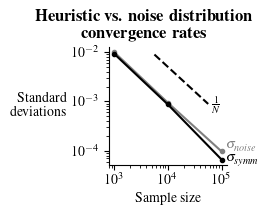

In [20]:
fig = plt.figure(figsize=(3.25,2.25))
ax = fig.add_subplot(111)   
 
ax.loglog(n_samples, noise_stds, '.-', color='grey')
ax.loglog(n_samples, symm_stds, 'k.-')

ax.set_ylabel('Standard\ndeviations', rotation=0, ha='right', va='center')
ax.set_xlabel('Sample size')
ax.annotate(r'$\sigma_{noise}$', (n_samples[-1]*1.2, noise_stds[-1]), ha='left', va='bottom', color='grey');
ax.annotate(r'$\sigma_{symm}$', (n_samples[-1]*1.2, symm_stds[-1]), ha='left', va='center', color='k');

rate_x = np.linspace(10**(3.75), 10**(4.75), 100)
rate_y = 50*rate_x**(-1)
ax.loglog(rate_x, rate_y, 'k--')
ax.annotate(r'$\frac{1}{N}$', (rate_x[-1]*1.35, rate_y[-1]), ha='center', va='center')

ax.spines[['top','right']].set_visible(False)
ax.set_title(r'\textbf{Heuristic vs. noise distribution}'+'\n'+r'\textbf{convergence rates}', x=0.3)

ax.set_box_aspect(1)
fig.tight_layout()
fig.savefig(f'{figdir}/heuristic_std_dev_convergence.pdf', bbox_inches='tight')